# Mapping and unsupervised clustering analysis for NI tests (Part 1)

### Requirements and dependencies

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.mixture import GaussianMixture

from Mapping import plot_pdf_with_deconvolution_on_axis
from Mapping import plot_cdf_with_weibull_fit_on_axis
from Mapping import plot_clustered_data
from Mapping import plot_map
from Mapping import plot_pixel_map

# Graphics settings
xDim = 4
yDim = 2
cMap = 'viridis'

### Specimen informations + Results path + Clustering method

In [2]:
# Sample 1
sampleNames = ['Synthetic_MatrixFibers']
file_paths = [Path("Dataset/MatrixFibers/synthetic_composite_data_ratio_E_3.xlsx")] # E_matrix / E_fiber = 3 and same similar hardness
file_paths = [Path("Dataset/MatrixFibers/synthetic_composite_data_ratio_E_1.5.xlsx")] # E_matrix / E_fiber = 1.5 and similar hardness
file_paths = [Path("Dataset/MatrixFibers/synthetic_composite_data_ratio_E_1.2.xlsx")] # E_matrix / E_fiber = 1.2 and similar hardness
sheet_name = 'Sheet1'

# Sample 2
#sampleNames = ['Ni_SiC']
#file_paths = [Path("Dataset/Ni_SiC/MTS_example1_25x25.xls")]
#file_paths = [Path("Dataset/Ni_SiC/MTS_example1_25x25.xls_interp_81x81.xls")] # To check effect of mapping resolution (artifically interpolated)
#sheet_name = 'Sample'

# Sample 3
# sampleNames = ['HSS-Steel_Carbides']
# file_paths = [Path("Dataset/HSS_Steel_Carbides/MTS_example1_25x25_flower.xls")]
# sheet_name = 'Sample'

# Create the directory if it doesn't exist using sample name
result_dir = Path("Results/2D_Clustering/" + sampleNames[0])
result_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Cluster the data using KMeans, or GMM...
method = 'KMeans'
#method = 'GMM'
# ... DBSCAN ?

### Loading dataset and make mechanical properties dataframe

In [4]:
# Import data from Excel files
data_frames = []
for file_path in file_paths:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    data_frames.append(df)
data = pd.concat(data_frames, ignore_index=True)

# Merge first row (containing units) with the header
data.columns = [f"{col}_{unit}" if unit else col for col, unit in zip(data.columns, data.iloc[0])]
data = data.drop(index=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='ignore')

# Replace empty strings with NaN
data.replace("", np.nan, inplace=True)

# Remove colums Markers and Index Integer
data.drop(columns=[col for col in data.columns if 'Markers_nan' in col or 'Index_Integer' in col], inplace=True)

print(data.head())

# Save as a .csv file in 'Results' folder
data.to_csv(result_dir / 'imported_data.csv', index=False)
print(f"Data saved to {result_dir / 'imported_data.csv'}")

   X Position_µm  Y Position_µm  MODULUS_GPa  HARDNESS_GPa
0       0.000000            0.0    14.188546      3.976281
1       1.010101            0.0    24.089080      4.972246
2       2.020202            0.0    15.854392      4.948846
3       3.030303            0.0    12.301837      5.567220
4       4.040404            0.0    19.584120      3.629354
Data saved to Results\2D_Clustering\Synthetic_MatrixFibers\imported_data.csv


C:\Users\dmercier\AppData\Local\Temp\ipykernel_12140\840631641.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Mapping analysis

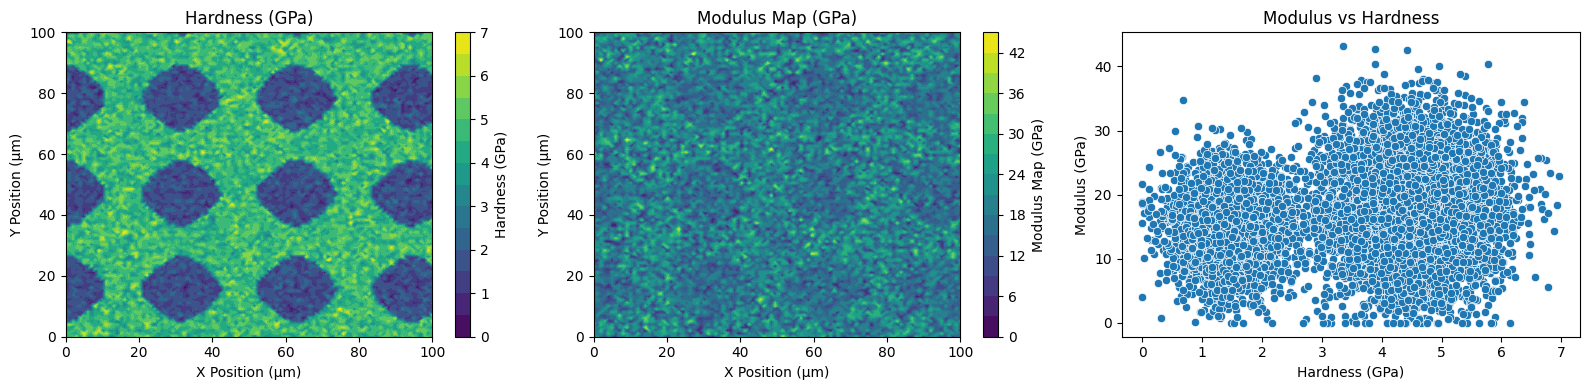

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

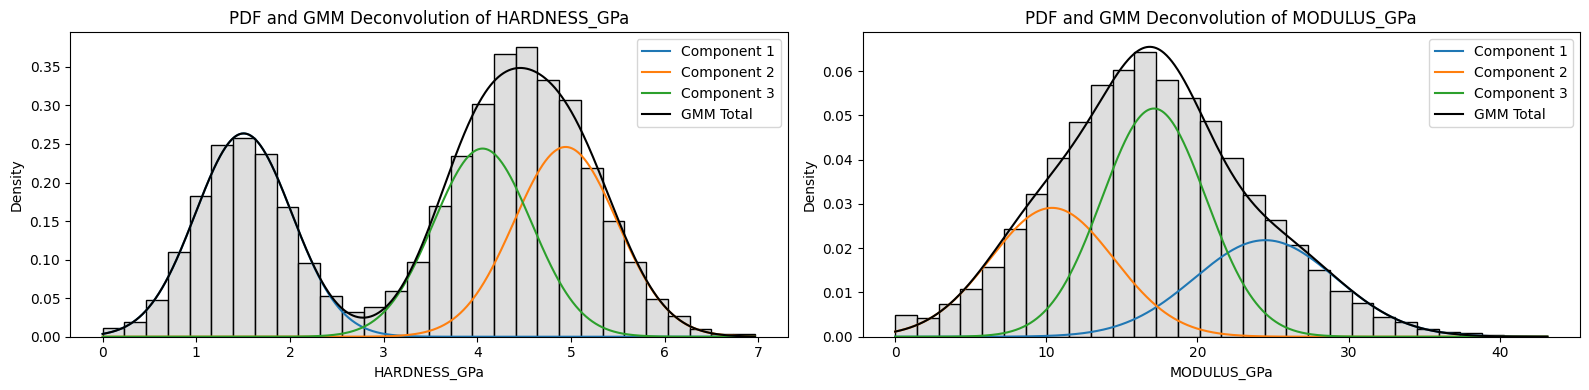

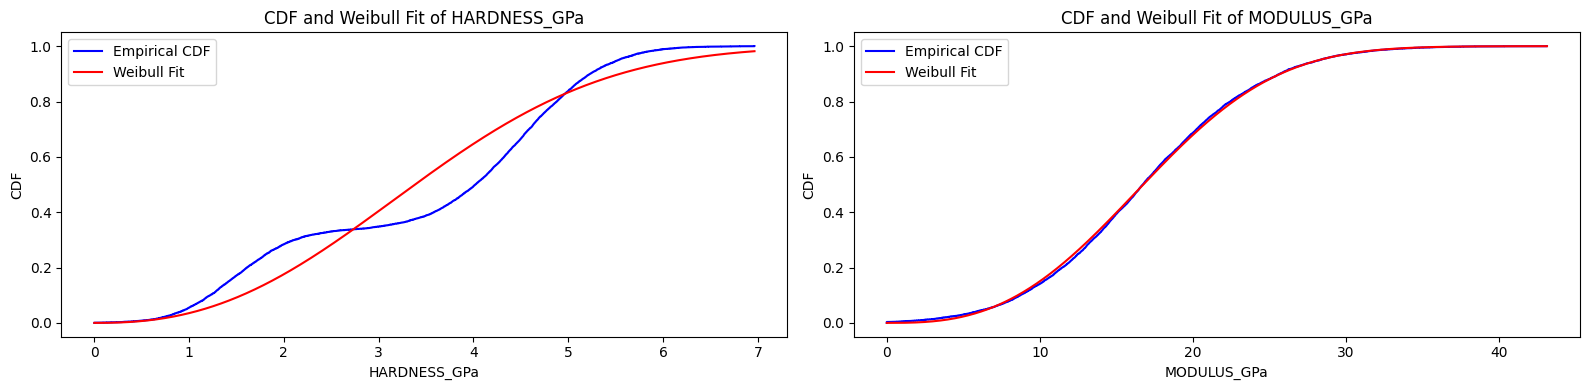

In [5]:
# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(4*xDim, 2*yDim))

# Plot Hardness map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['HARDNESS_GPa'], 
         title='Hardness (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[0], cmap=cMap)

plot_map(data['X Position_µm'], data['Y Position_µm'], data['MODULUS_GPa'], 
         title='Modulus Map (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[1], cmap=cMap)

# Plot Modulus vs Hardness
sns.scatterplot(y='MODULUS_GPa', x='HARDNESS_GPa', data=data, ax=axes[2])  # Pass the third subplot axis
axes[2].set_title('Modulus vs Hardness')
axes[2].set_ylabel('Modulus (GPa)')
axes[2].set_xlabel('Hardness (GPa)')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'maps_and_scatter.png')
plt.show()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

n_componentsVal = 3  # Adjust based on expected number of phases

# Plot PDF and GMM Deconvolution for Hardness
plot_pdf_with_deconvolution_on_axis(data, 'HARDNESS_GPa', n_components=n_componentsVal, ax=axes[0])
# Plot PDF and GMM Deconvolution for Modulus
plot_pdf_with_deconvolution_on_axis(data, 'MODULUS_GPa', n_components=n_componentsVal, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'pdf_gmm_deconvolution.png')
plt.show()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

# Plot CDF and Weibull fit for Hardness
plot_cdf_with_weibull_fit_on_axis(data, 'HARDNESS_GPa', ax=axes[0])
# Plot CDF and Weibull fit for Modulus
plot_cdf_with_weibull_fit_on_axis(data, 'MODULUS_GPa', ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'cdf_weibull_fit.png')
plt.show()


### Matrix correlation analysis

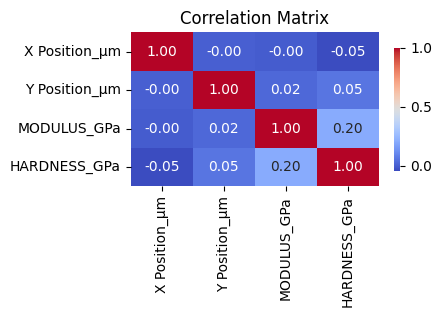

In [6]:
# Plot matrix correlation
plt.figure(figsize=(xDim, yDim))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig(result_dir / 'correlation_matrix.png')
plt.show()

### Clustering analysis - Number of clusters estimation

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\

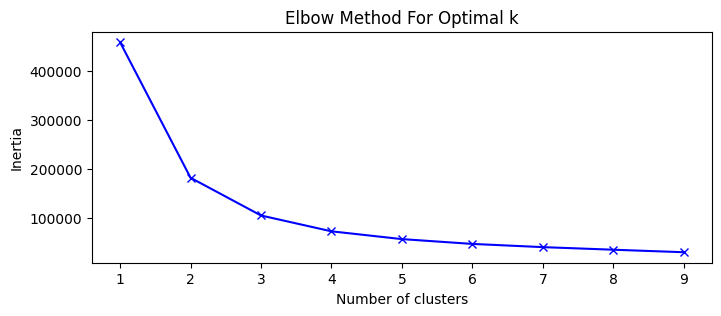

Optimal number of clusters: 3


In [7]:
if method == 'KMeans':
    # Determine optimal number of clusters using Elbow Method
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.savefig(result_dir / 'elbow_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, inertia, curve="convex", direction="decreasing")
    optimal_k = knee_locator.knee

elif method == 'GMM':
    # Determine optimal number of clusters using BIC
    bics = []
    K = range(1, 10)
    for k in K:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        bics.append(gmm.bic(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna()))

    # Plot the BIC
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, bics, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.title('BIC For Optimal k')
    plt.savefig(result_dir / 'bic_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, bics, curve="convex", direction="increasing")
    optimal_k = knee_locator.knee
    
print(f"Optimal number of clusters: {optimal_k}")
#optimal_k = 3  # Manually set for demonstration purposes

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)

### Clustering analysis - K-means clustering

   HARDNESS_GPa  MODULUS_GPa  Cluster
0      3.976281    14.188546        0
1      4.972246    24.089080        1
2      4.948846    15.854392        0
3      5.567220    12.301837        2
4      3.629354    19.584120        0


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustered data plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\KMeans_Clustering_of_Hardness_and_Modulus.png


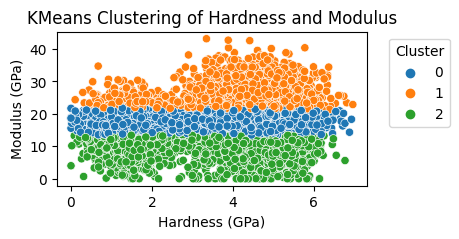

Pixel map plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\kmeans_clusters_map.png


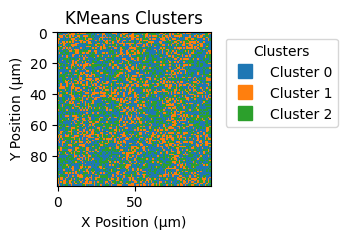

        HARDNESS_GPa                               MODULUS_GPa            \
                mean       std       min       max        mean       std   
Cluster                                                                    
0           3.357167  1.597932  0.000000  6.932223   17.334130  2.279122   
1           4.123367  1.203522  0.102712  6.964885   25.794622  3.510161   
2           3.196395  1.621887  0.000000  6.772091    9.523109  3.113896   

                              Count  
               min        max count  
Cluster                              
0        13.379528  21.783276  4634  
1        21.383560  43.156453  2373  
2         0.000000  13.465509  2993  
Cluster 0: 4634 points, 46.34%
Cluster 1: 2373 points, 23.73%
Cluster 2: 2993 points, 29.93%
NaN or empty data: 0 points, 0.00%
Total ratio: 100.00%


In [8]:
if method == 'KMeans':
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
elif method == 'GMM':
    kmeans = GaussianMixture(n_components=optimal_k, random_state=42)

data = data.dropna(subset=['HARDNESS_GPa', 'MODULUS_GPa']).reset_index(drop=True)

if method == 'KMeans':
    data['Cluster'] = kmeans.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])
elif method == 'GMM':
    data['Cluster'] = kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']]).predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])

data['Cluster'] = data['Cluster'].astype(int)
print(data[['HARDNESS_GPa', 'MODULUS_GPa', 'Cluster']].head())

# Plot clustered data using colors defined above
plot_clustered_data(data, 'HARDNESS_GPa','MODULUS_GPa', 'Cluster',
                    colors, result_dir, xDim, yDim, 
                    'KMeans Clustering of Hardness and Modulus', 'Hardness (GPa)', 'Modulus (GPa)')

# Create a colormap for clusters
cmap = {i: colors[i] for i in range(optimal_k)}
data['Cluster_Color'] = data['Cluster'].map(cmap)

# Plot clusters on spatial map with square pixels
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='KMeans Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=cmap, save_path=result_dir / 'kmeans_clusters_map.png')

# Print cluster statistics
cluster_stats = data.groupby('Cluster').agg({
    'HARDNESS_GPa': ['mean', 'std', 'min', 'max'],
    'MODULUS_GPa': ['mean', 'std', 'min', 'max'],
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

print(cluster_stats)

# Print clusters ratio in %
total_points = len(data)
for cluster in range(optimal_k):
    count = len(data[data['Cluster'] == cluster])
    ratio = (count / total_points) * 100
    print(f"Cluster {cluster}: {count} points, {ratio:.2f}%")
# Print NaN or empty data ratio in %
nan_count = data[['HARDNESS_GPa', 'MODULUS_GPa']].isna().any(axis=1).sum()
nan_ratio = (nan_count / (total_points + nan_count)) * 100
print(f"NaN or empty data: {nan_count} points, {nan_ratio:.2f}%")
# Check that all % make 100%
total_ratio = sum((len(data[data['Cluster'] == cluster]) / total_points) * 100 for cluster in range(optimal_k)) + nan_ratio
print(f"Total ratio: {total_ratio:.2f}%")


### All plots

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\dmercier\AppData\Local\Temp\ipykernel_12140\2073133692.py:63: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fi

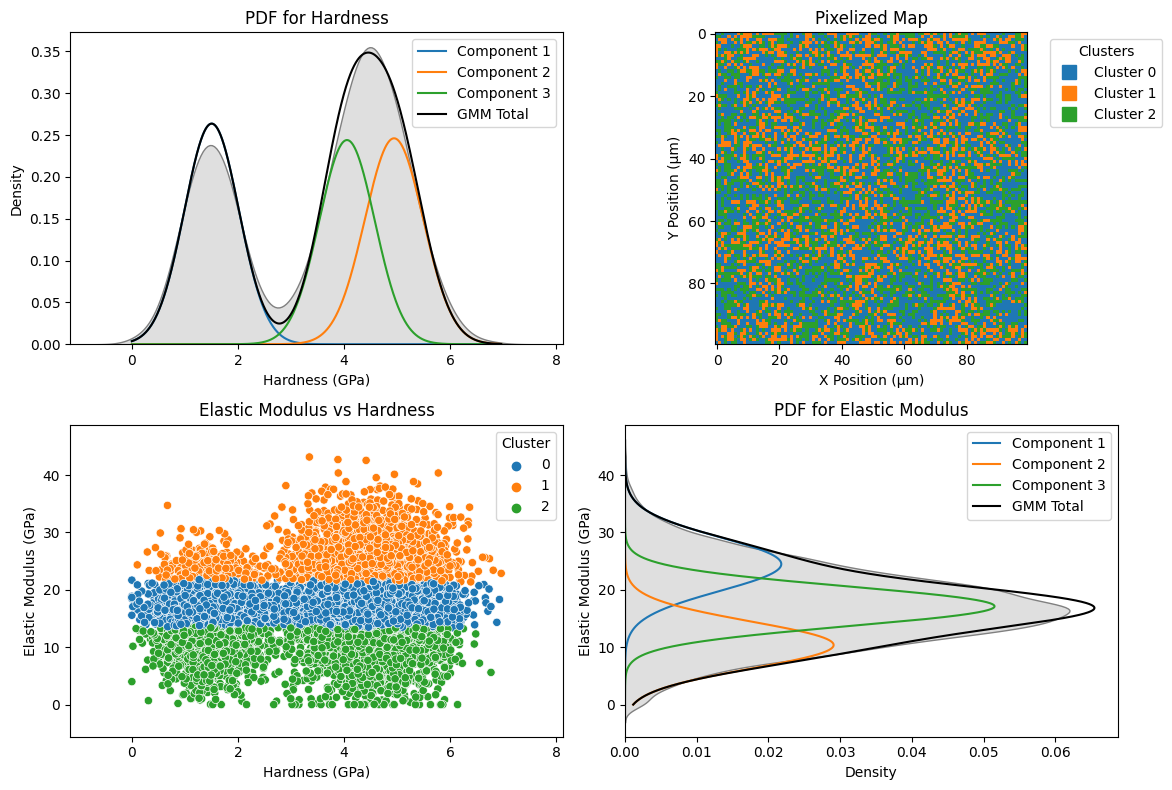

In [9]:
# Define the number of clusters
optimal_k = len(data['Cluster'].unique())

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)
cluster_cmap = ListedColormap(colors)

# Pivot data for pixelized map (handle duplicates by aggregating with pivot_table)
grid_data = data.pivot_table(
    index='Y Position_µm',
    columns='X Position_µm',
    values='Cluster',
    aggfunc='mean'  # You can use 'mean', 'median', or another aggregation function
)
grid_data = grid_data.sort_index(ascending=False)  # Ensure proper orientation

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(3*xDim, 4*yDim))

# Top Left: PDF for Hardness
sns.kdeplot(data['HARDNESS_GPa'], ax=axes[0, 0], fill=True, color='gray')
axes[0, 0].set_title('PDF for Hardness')
axes[0, 0].set_xlabel('Hardness (GPa)')
axes[0, 0].set_ylabel('Density')
# Add Deconvolution with peaks with same colors as corresponding clusters
n_componentsVal = optimal_k  # Use the optimal number of clusters determined earlier
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['HARDNESS_GPa']].dropna())
x = np.linspace(data['HARDNESS_GPa'].min(), data['HARDNESS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[0, 0].plot(x, responsibilities[:, i] * pdf, label=f'Component {i+1}', color=colors[i])
axes[0, 0].plot(x, pdf, '-k', label='GMM Total')
axes[0, 0].legend()

# Top Right: Pixelized Map
im = axes[0, 1].imshow(grid_data, cmap=cluster_cmap, aspect='equal', interpolation='none')
axes[0, 1].set_title('Pixelized Map')
axes[0, 1].set_xlabel('X Position (µm)')
axes[0, 1].set_ylabel('Y Position (µm)')

# Create discrete legend handles for clusters
unique_clusters = np.unique(grid_data[~np.isnan(grid_data)])  # Exclude NaN values
handles = [
    plt.Line2D(
        [0], [0], 
        marker='s', 
        color=cluster_cmap(cluster / len(unique_clusters)), 
        linestyle='', 
        markersize=10, 
        label=f'Cluster {int(cluster)}'
    ) 
    for cluster in unique_clusters if not np.isnan(cluster)  # Ensure cluster is not NaN
]

# Add the discrete legend
axes[0, 1].legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottom Right: PDF for Elastic Modulus rotated 90°
sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fill=True, color='gray', vertical=True)
axes[1, 1].set_title('PDF for Elastic Modulus')
axes[1, 1].set_xlabel('Density')
axes[1, 1].set_ylabel('Elastic Modulus (GPa)')
# Add Deconvolution with peaks with same colors as corresponding clusters
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['MODULUS_GPa']].dropna())
x = np.linspace(data['MODULUS_GPa'].min(), data['MODULUS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[1, 1].plot(responsibilities[:, i] * pdf, x, label=f'Component {i+1}', color=colors[i])
axes[1, 1].plot(pdf, x, '-k', label='GMM Total')
axes[1, 1].legend()

# Bottom Left: Elastic Modulus vs Hardness with same axis scale than PDFs plots
sns.scatterplot(x='HARDNESS_GPa', y='MODULUS_GPa', hue='Cluster', palette=colors, data=data, ax=axes[1, 0])
axes[1, 0].set_title('Elastic Modulus vs Hardness')
axes[1, 0].set_xlabel('Hardness (GPa)')
axes[1, 0].set_ylabel('Elastic Modulus (GPa)')
axes[1, 0].set_xlim(axes[0, 0].get_xlim())
axes[1, 0].set_ylim(axes[1, 1].get_ylim())
axes[1, 0].legend(title='Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

### Principle component analysis (PCA)

Clustered data plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\PCA_of_Hardness_and_Modulus.png


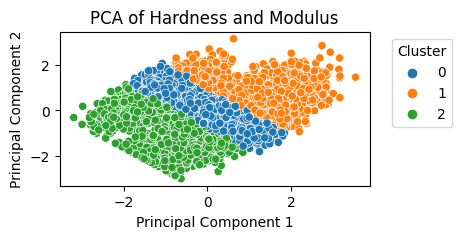

Pixel map plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\spatial_clusters_pca.png


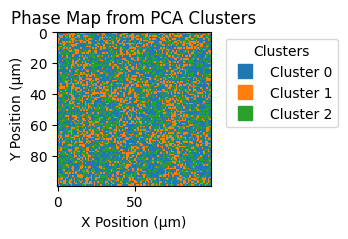

In [10]:
# Investigate Principle Component Analysis (PCA)
# scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
features = ['HARDNESS_GPa', 'MODULUS_GPa']
x = StandardScaler().fit_transform(data[features])
# Apply PCA --> reducing the dimensionality for visualization purposes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = data['Cluster'].values

# Plot PCA results
plot_clustered_data(pc_df, 'PC1', 'PC2', 'Cluster',        
                    colors, result_dir, xDim, yDim, 
                    'PCA of Hardness and Modulus', 'Principal Component 1', 'Principal Component 2')

# Plot the corresponding phase map
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='Phase Map from PCA Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=cmap, save_path=result_dir / 'spatial_clusters_pca.png')

### Agglomerative clustering

Clustered data plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\Clustered_Data_in_PCA_Space.png


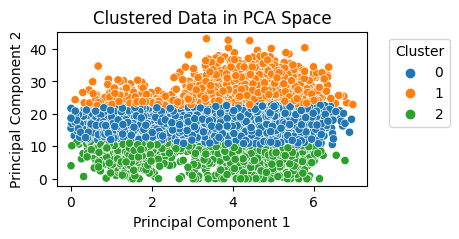

Pixel map plot saved to Results\2D_Clustering\Synthetic_MatrixFibers\spatial_clusters_agglo.png


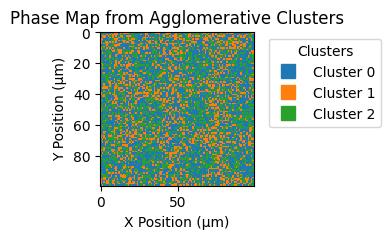

In [11]:
# Agglomerative Clustering
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=optimal_k)
data['Agglo_Cluster'] = agglo.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])

# Plot Agglomerative Clustering results
plot_clustered_data(data,'HARDNESS_GPa', 'MODULUS_GPa', 'Agglo_Cluster', 
                    colors, result_dir, xDim, yDim, 
                    'Clustered Data in PCA Space', 'Principal Component 1', 'Principal Component 2')

# Plot the corresponding phase map
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='Phase Map from Agglomerative Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=cmap, save_path=result_dir / 'spatial_clusters_agglo.png')
